### Here we will explore the human body dimensions data, specifically we will find the tallest and shortest subjects. We have to do that because we have to establish the range of the camera distance to the meshes to ensure that the subject appears completelly on the image. 

In [1]:
# we do need python 3.7 for using blender python (bpy)
import platform
assert(platform.python_version()[:3] == "3.7")

In [5]:
# As info, but the needed packages are HBM, Vedo, Trimesh, Sklearn, Matplotlib, and Neural Anthropometer
!pip list

Package                       Version   Location
----------------------------- --------- ----------------------------------
about-time                    3.1.1
absl-py                       1.1.0
alabaster                     0.7.12
alive-progress                2.3.1
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astor                         0.8.1
astroid                       2.9.3
astunparse                    1.6.3
atomicwrites                  1.4.0
attrs                         21.4.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.1.0
binaryornot                   0.4.4
black                         22.1.0
bleach                        4.1.0
bpy                           2.91a0
cachetools                    4.2.4
certifi                       2021.10.8
cffi                          1.15.0
chardet                       4.0.0
charset-normalizer            2.0.12


In [2]:
import numpy as np
import neural_anthropometer as na
import pandas as pd
import os
import datetime
import bpy
import sys
from mathutils import Matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
# The basic dataset to iterate
root_dir = os.path.join("..", "dataset")

dataset = na.NeuralAnthropometerSyntheticImagesDataset(
    root_dir=root_dir, load_images=False
)


ValueError: ../dataset does not exist!

In [36]:
dataset_len = len(dataset)
hbds = []
for i in range(dataset_len):
    sample = dataset[i]
    hbds.append(sample["annotations"]["human_dimensions"])
try:
    df = pd.DataFrame(hbds, columns=[k for k in hbds[0].keys()])
except:
    df = pd.DataFrame(hbds, columns=[*hbds[0]])

In [24]:
# The index is the element index in the dataset. Therefore, we can access it to ontain the subject information.
print(df)

       chest_circumference    height    inseam  left_arm_length  \
0                 1.222634  1.487929  0.514846         0.485513   
1                 0.897109  1.792233  0.866951         0.628930   
2                 1.060962  1.509208  0.620023         0.487811   
3                 1.038552  1.406485  0.550867         0.482332   
4                 1.141386  1.733648  0.712549         0.602596   
...                    ...       ...       ...              ...   
11995             0.970733  1.585548  0.620002         0.507966   
11996             1.148296  2.058362  0.964505         0.665603   
11997             1.280049  2.017968  0.830021         0.635260   
11998             1.007737  1.674184  0.749391         0.542691   
11999             1.296615  1.796327  0.713101         0.573946   

       pelvis_circumference  right_arm_length  shoulder_width  \
0                  1.155255          0.462298        0.389854   
1                  1.058323          0.620611        0.326742   


In [25]:
# Get statistics for height
df['height'].describe()

count    12000.000000
mean         1.725063
std          0.146786
min          1.393659
25%          1.612819
50%          1.721853
75%          1.832912
max          2.071911
Name: height, dtype: float64

In [44]:
import json
print(json.dumps(dataset[0], indent=4, sort_keys=True))

{
    "annotation_file": "../dataset/annotations/female/subject_mesh_0001_anno.json",
    "annotations": {
        "betas": [
            [
                -2.2828900814056396,
                -2.68319034576416,
                2.343587875366211,
                -2.390784978866577,
                -1.7064950466156006,
                -0.5488943457603455,
                2.6963765621185303,
                -2.4994277954101562,
                1.9967756271362305,
                -2.175292491912842
            ]
        ],
        "human_dimensions": {
            "chest_circumference": 1.222633626253291,
            "height": 1.4879293683226364,
            "inseam": 0.5148462331886291,
            "left_arm_length": 0.48551271453756933,
            "pelvis_circumference": 1.1552546402997685,
            "right_arm_length": 0.46229802258610425,
            "shoulder_width": 0.3898538812961059,
            "waist_circumference": 1.0551186523883962
        }
    },
    "image": null,
    "

In [30]:
# Get max
max_subject_hight = round(df['height'].max(), 2)
max_subject_index = df['height'].idxmax()
max_subject_sample = dataset[max_subject_index]
max_subject_string = max_subject_sample["subject_string"]
print("Tallest subject is {}, height is {} m, index is {}.".format(
    max_subject_string,
    max_subject_hight,
    max_subject_index))

Tallest subject is Male subject 2531 in pose 0, height is 2.07 m, index is 5530.


In [31]:
# Get min
min_subject_hight = round(df['height'].min(), 2)
min_subject_index = df['height'].idxmin()
min_subject_sample = dataset[min_subject_index]
min_subject_string = min_subject_sample["subject_string"]
print("Shortest subject is {}, height is {} m, index is {}.".format(
    min_subject_string,
    min_subject_hight,
    min_subject_index))

Shortest subject is Female subject 2333 in pose 0, height is 1.39 m, index is 2332.


In [82]:
# Define function to "take a picture" (simulate taking a photo)
# of a subject to observe if the subject is completely in the image.
def take_picture(subject_file, camdis, image_file, info=True):
    """
    Simulate taking a photo from a subject at a given camera distance.
    subject: ND-Array, 3D human mesh
    camdis: Integer, camera distance in meters.
    At the momment it is almost impossible to render a image "in the fly" with
    bpy. Therefore, we save the image.
    """
    # init scene
    scene = bpy.data.scenes["Scene"]
    # blender < v 2.80
    # scene.render.engine = "BLENDER_RENDER"
    scene.render.engine = "CYCLES"
    # scene.render.engine = "BLENDER_EEVEE"
    # set camera properties and initial position
    cam_ob = bpy.data.objects["Camera"]
    # scene.objects.active = cam_ob


    # This is a standard focal length (for most purposes 35mm-85mm)
    cam_ob.data.lens = 60
    # Clipping is related to the depth of field (DoF). Rendering will start and end
    # at this depth values.
    cam_ob.data.clip_start = 0.1
    cam_ob.data.clip_end = 100
    # (default) cam_ob.data.sensor_fit = AUTO
    cam_ob.data.sensor_width = 32
    # (default) cam_ob.data.sensor_hight = 18
    # Use perspective projection
    cam_ob.data.type = "PERSP"
    # delete the default cube (which held the material) if any
    try:
        bpy.data.objects["Cube"].select_set(True)
        bpy.ops.object.delete()
    except:
        if info:
            print("No default cube found")

    # position the lamp in front of the camara as simulating a "real lamp"
    # hanging from the celling
    lamp_objects = [o for o in bpy.data.objects if o.type == "LAMP"]

    # if there are no lamps we add one
    if len(lamp_objects) == 0:
        # Create new lamp datablock
        # blender < v 2.80
        lamp_data = bpy.data.lights.new(name="Lamp", type="POINT")
        # lamp_data = bpy.ops.object.light_add(type='POINT')

        # Create new object with our lamp datablock
        lamp = bpy.data.objects.new(name="Lamp", object_data=lamp_data)

        # Link lamp object to the scene so it'll appear in this scene
        # Links object to the master collection of the scene.
        scene.collection.objects.link(lamp)

        # link light object
        bpy.context.collection.objects.link(lamp)
        if info:
            print("Lamp object was created")
    else:
        lamp = lamp_objects[0]

    lamp.matrix_world = Matrix(
        (
            (1.0, 0.0, 0.0, 0.10113668441772461),
            (0.0, 1.0, 0.0, -0.8406344056129456),
            (0.0, 0.0, 1.0, 1.4507088661193848),
            (0.0, 0.0, 0.0, 1.0),
        )
    )

    # 200 pixels in the x direction
    bpy.context.scene.render.resolution_x = 200
    # 200 pixels in the y direction
    bpy.context.scene.render.resolution_y = 200
    # "Percentage scale for render resolution"
    bpy.context.scene.render.resolution_percentage = 100

    # save a grayscale(BlackWhite) png image
    scene.render.image_settings.color_mode = "BW"
    scene.render.image_settings.file_format = "PNG"
    # set the background color to white (R, G, B)
    bpy.data.worlds["World"].node_tree.nodes["Background"].inputs[
        0
    ].default_value = (1, 1, 1, 1)
    
    # Place the camera in the right location.
    # This matrix is directly taken from blender.
    cam_ob.matrix_world = Matrix(
        (
            (1.0, 0.0, 0.0, 0.0),
            (0.0, 0.08715556561946869, -0.9961947202682495, camdis),
            (0.0, 0.9961947202682495, 0.08715556561946869, 0.0),
            (0.0, 0.0, 0.0, 1.0),
        )
    )
    
    # Deselect everthing
    bpy.ops.object.select_all(action="DESELECT")

    bpy.ops.import_scene.obj(filepath=subject_file)
    if info:
        print("Object {} has been imported".format(subject_file))
    print(bpy.data.objects[subject_file[-21:-4]])
    # select this object
    imported_object = bpy.data.objects[subject_file[-21:-4]]
    imported_object.select_set(True)

    # print('Imported name: ', obj_object.name)
    imported_object.data.use_auto_smooth = (
        False  # autosmooth creates artifacts
    )
    # change Base Color
    bpy.data.materials["Material"].node_tree.nodes["Principled BSDF"].inputs[
        0
    ].default_value = (0.111, 0.111, 0.111, 1)
    # change Subsurface Color
    bpy.data.materials["Material"].node_tree.nodes["Principled BSDF"].inputs[
        3
    ].default_value = (0, 0, 0, 1)
    # change Emission
    bpy.data.materials["Material"].node_tree.nodes["Principled BSDF"].inputs[
        17
    ].default_value = (0, 0, 0, 1)

    imported_object.active_material = bpy.data.materials["Material"]
    # update scene, if needed
    layer = bpy.context.view_layer
    layer.update()

    # blender < v2.80
    # scene.render.use_antialiasing = True
    # bpy.context.scene.display.render_aa = 'OFF'
    scene.render.filepath = image_file
    # disable render output
    logfile = "/dev/null"
    open(logfile, "a").close()
    old = os.dup(1)
    sys.stdout.flush()
    os.close(1)
    os.open(logfile, os.O_WRONLY)

    # Render
    bpy.ops.render.render(write_still=True)

    # now delete this mesh and update
    bpy.ops.object.delete()
    # print('Object %s deleted.' % obj_object.name)
    to_remove = [block for block in bpy.data.meshes if block.users == 0]
    for block in to_remove:
        bpy.data.meshes.remove(block)

    layer = bpy.context.view_layer
    layer.update()

    # disable output redirection
    os.close(1)
    os.dup(old)
    os.close(old)

In [108]:
rendered_photo_file_dir = os.path.join("..", "img")
photo_timestamp = datetime.datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
max_subject_photo_image_path = os.path.join(
                                        rendered_photo_file_dir,
                                     "photo_" + max_subject_sample["meshfile"][-21:-4] + photo_timestamp + ".png")

print("Taking a foto from the tallest subject. Subject mesh filepath is {}, rendered image file is {}.".format(
    max_subject_sample["meshfile"],
    max_subject_photo_image_path))

take_picture(max_subject_sample["meshfile"], -3, max_subject_photo_image_path)

Taking a foto from the tallest subject. Subject mesh filepath is ../dataset/human_body_meshes/pose0/male/subject_mesh_2531.obj, rendered image file is ../img/photo_subject_mesh_253121-02-2022_18-12-09.png.
No default cube found
Lamp object was created
(  0.0000 sec |   0.0000 sec) Importing OBJ '../dataset/human_body_meshes/pose0/male/subject_mesh_2531.obj'...
  (  0.0003 sec |   0.0002 sec) Parsing OBJ file...
    (  0.0419 sec |   0.0416 sec) Done, loading materials and images...
    (  0.0422 sec |   0.0418 sec) Done, building geometries (verts:6890 faces:13776 materials: 1 smoothgroups:0) ...
    (  0.0728 sec |   0.0724 sec) Done.
  (  0.0729 sec |   0.0728 sec) Finished importing: '../dataset/human_body_meshes/pose0/male/subject_mesh_2531.obj'
Progress: 100.00%

Object ../dataset/human_body_meshes/pose0/male/subject_mesh_2531.obj has been imported
<bpy_struct, Object("subject_mesh_2531") at 0x560a522f08a8>
Info: Deleted 1 object(s)


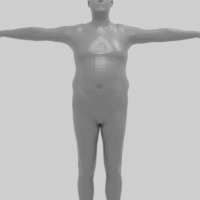

In [109]:
from IPython.display import display, Image
display(Image(filename=max_subject_photo_image_path))

As we can see in the image above, placing the camera at 3m is to close for the tallest subject. Visually inspecting the images, we found that 4.2m camera distance is about right.

In [116]:
take_picture(max_subject_sample["meshfile"], -4.2, max_subject_photo_image_path)

No default cube found
Lamp object was created
(  0.0002 sec |   0.0002 sec) Importing OBJ '../dataset/human_body_meshes/pose0/male/subject_mesh_2531.obj'...
  (  0.0004 sec |   0.0002 sec) Parsing OBJ file...
    (  0.0932 sec |   0.0928 sec) Done, loading materials and images...
    (  0.0937 sec |   0.0933 sec) Done, building geometries (verts:6890 faces:13776 materials: 1 smoothgroups:0) ...
    (  0.1239 sec |   0.1234 sec) Done.
  (  0.1240 sec |   0.1237 sec) Finished importing: '../dataset/human_body_meshes/pose0/male/subject_mesh_2531.obj'
Progress: 100.00%

Object ../dataset/human_body_meshes/pose0/male/subject_mesh_2531.obj has been imported
<bpy_struct, Object("subject_mesh_2531") at 0x560a520811c8>
Info: Deleted 1 object(s)


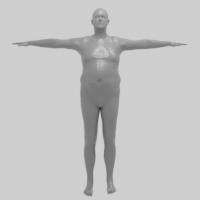

In [117]:
from IPython.display import display, Image
display(Image(filename=max_subject_photo_image_path))

In [124]:
min_subject_photo_image_path = os.path.join(
                                        rendered_photo_file_dir,
                                     "photo_" + min_subject_sample["meshfile"][-21:-4] + photo_timestamp + ".png")

print("Taking a foto from the shortest subject. Subject mesh filepath is {}, rendered image file is {}.".format(
    min_subject_sample["meshfile"],
    min_subject_photo_image_path))

take_picture(min_subject_sample["meshfile"], -7.2, min_subject_photo_image_path)

Taking a foto from the shortest subject. Subject mesh filepath is ../dataset/human_body_meshes/pose0/female/subject_mesh_2333.obj, rendered image file is ../img/photo_subject_mesh_233321-02-2022_18-12-09.png.
No default cube found
Lamp object was created
(  0.0001 sec |   0.0001 sec) Importing OBJ '../dataset/human_body_meshes/pose0/female/subject_mesh_2333.obj'...
  (  0.0003 sec |   0.0002 sec) Parsing OBJ file...
    (  0.0928 sec |   0.0925 sec) Done, loading materials and images...
    (  0.0931 sec |   0.0928 sec) Done, building geometries (verts:6890 faces:13776 materials: 1 smoothgroups:0) ...
    (  0.1238 sec |   0.1235 sec) Done.
  (  0.1240 sec |   0.1239 sec) Finished importing: '../dataset/human_body_meshes/pose0/female/subject_mesh_2333.obj'
Progress: 100.00%

Object ../dataset/human_body_meshes/pose0/female/subject_mesh_2333.obj has been imported
<bpy_struct, Object("subject_mesh_2333") at 0x560a5278ad88>
Info: Deleted 1 object(s)


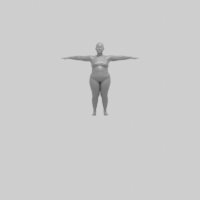

In [125]:
display(Image(filename=min_subject_photo_image_path))

Similarly, we consider that placing the camera at 7.2m in front of the subject is far enough. If we place the camera farther, the subject appears too small in the picture.